In [2]:
import pandas as pd
import numpy as np

def compute_asymmetry_raw(csv_path):
    df = pd.read_csv(csv_path)

    # depth axis is X (raw SRIM geometry)
    x = df["x"].values
    
    # sort points by depth
    idx = np.argsort(x)
    x_sorted = x[idx]

    N = len(x_sorted)
    if N < 3:
        return None

    # divide into three equal depth sections
    third = N // 3
    first = x_sorted[:third]
    last  = x_sorted[-third:]

    N_first = len(first)
    N_last  = len(last)

    if N_first == 0:
        return None

    asym = N_last / N_first
    return asym

In [ ]:
results = pd.read_csv("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv")
valid = results[results["status"] == "OK"].copy()

asym = []
true_par = []
file_list = []

for _, row in valid.iterrows():
    a = compute_asymmetry_raw(row["csv_path"])
    if a is None:
        continue
    asym.append(a)
    true_par.append(row["true_parity"])
    file_list.append(row["csv_path"])

asym = np.array(asym)
true_par = np.array(true_par)

NameError: name 'valid' is not defined

In [ ]:
def evaluate_threshold(asym, true_par, t):
    preds = (asym > t).astype(int)
    acc = (preds == true_par).mean()
    return acc

In [ ]:
thresholds = np.linspace(asym.min(), asym.max(), 200)
accs = [evaluate_threshold(asym, true_par, t) for t in thresholds]

best_t = thresholds[np.argmax(accs)]
best_acc = max(accs)

print("Best threshold:", best_t)
print("Best asymmetry parity accuracy:", best_acc)

In [ ]:
t_opt, best_acc = find_best_threshold(asym_list, true_list)
print("Best threshold:", t_opt)
print("Rajendran-style asymmetry accuracy:", best_acc)

In [12]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1) Load your RAW SRIM vacancy table (the huge CSV)
# ---------------------------------------------------------
RAW_FILE = "//Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/centered_tracks.csv"

df = pd.read_csv(RAW_FILE)

# safety: drop rows missing parity
df = df.dropna(subset=["parity"])

# Convert parity to int if needed
df["parity"] = df["parity"].astype(int)

# ---------------------------------------------------------
# 2) Group by track_id (Rajendran works per track)
# ---------------------------------------------------------
tracks = df.groupby("track_id")


# ---------------------------------------------------------
# 3) Rajendran asymmetry computation for ONE track
# ---------------------------------------------------------
def compute_asymmetry(track_df):
    """
    Rajendran asymmetry:
    A = (# points in final 1/3 of x-range) / (# points in first 1/3)
    """
    x = track_df["x"].values

    # sort by depth (raw)
    order = np.argsort(x)
    x_sorted = x[order]

    N = len(x_sorted)
    if N < 3:
        return None

    third = N // 3
    first  = x_sorted[:third]
    last   = x_sorted[-third:]

    if len(first) == 0:
        return None

    return len(last) / len(first)


# ---------------------------------------------------------
# 4) Build dataset of asymmetry values + true parity
# ---------------------------------------------------------
asym_list = []
true_par_list = []

for tid, tdf in tracks:
    A = compute_asymmetry(tdf)
    if A is None:
        continue
    asym_list.append(A)
    true_par_list.append(tdf["parity"].iloc[0])

asym_list = np.array(asym_list)
true_par_list = np.array(true_par_list)

print("Computed asymmetry for", len(asym_list), "tracks")


# ---------------------------------------------------------
# 5) Sweep threshold → find best classifier
# ---------------------------------------------------------

def evaluate_threshold(t):
    pred = (asym_list > t).astype(int)
    return (pred == true_par_list).mean()

thresholds = np.linspace(asym_list.min(), asym_list.max(), 500)
accuracies = np.array([evaluate_threshold(t) for t in thresholds])

best_idx = np.argmax(accuracies)
best_t = thresholds[best_idx]
best_acc = accuracies[best_idx]

print("\n===== Rajendran Baseline =====")
print(f"Best threshold = {best_t:.4f}")
print(f"Best parity accuracy = {best_acc*100:.2f}%")
print("==============================\n")

KeyError: 'track_id'

In [14]:
import pandas as pd
import numpy as np

# ============================================================
# 1) LOAD YOUR RAW SRIM TRACK FILE (centered but NOT flipped)
# ============================================================
raw = pd.read_csv(
    "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/centered_tracks.csv"
)

# Your columns are: x, y, z, ion_number, energy, parity
# We MUST make a proper track ID:
raw["track_id"] = raw["ion_number"].astype(str) + "_" + raw["energy"].astype(str)

print("Loaded raw points:", len(raw))
print("Unique tracks:", raw["track_id"].nunique())


# ============================================================
# 2) COMPUTE ASYMMETRY PER TRACK (Rajendran definition)
# ============================================================

def compute_asymmetry_for_track(df_track):
    """
    A = (# vacancies in last 1/3 of depth) / (# in first 1/3)
    Depth axis = x (raw or centered is OK, but MUST NOT be flipped).
    """

    x = np.array(df_track["x"])
    idx = np.argsort(x)
    x_sorted = x[idx]

    N = len(x_sorted)
    if N < 3:
        return None

    third = N // 3
    start = x_sorted[:third]
    end   = x_sorted[-third:]

    if len(start) == 0:
        return None

    return len(end) / len(start)


# Group into tracks
groups = raw.groupby("track_id")

asym_list = []
true_list = []

for track_id, g in groups:
    a = compute_asymmetry_for_track(g)
    if a is None:
        continue
    
    asym_list.append(a)
    # true parity is constant within the track → take first
    true_list.append(int(g["parity"].iloc[0]))

asym_list = np.array(asym_list)
true_list = np.array(true_list)

print("Computed asymmetries:", len(asym_list))
print("Parities:", set(true_list))


# ============================================================
# 3) HIGH-LEVEL CLASSIFIER: threshold on asymmetry
# ============================================================

def evaluate_threshold(asym, truth, t):
    preds = (asym > t).astype(int)
    return (preds == truth).mean()

thresholds = np.linspace(asym_list.min(), asym_list.max(), 400)
accuracies = [evaluate_threshold(asym_list, true_list, t) for t in thresholds]

best_idx = np.argmax(accuracies)
best_t = thresholds[best_idx]
best_acc = accuracies[best_idx]

print("\n==============================")
print(" Rajendran Method Baseline")
print("==============================")
print(f"Best threshold = {best_t:.4f}")
print(f"Best possible parity accuracy = {best_acc*100:.2f}%")
print("==============================\n")

Loaded raw points: 897447
Unique tracks: 4600
Computed asymmetries: 4600
Parities: {0, 1}

 Rajendran Method Baseline
Best threshold = 1.0000
Best possible parity accuracy = 50.00%



In [17]:
import pandas as pd
import numpy as np

RAW_SRIM = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv"

print("Loading large SRIM file...")
df = pd.read_csv(RAW_SRIM)

# Sort for consistency
df = df.sort_values(["energy", "ion_number"])
df.reset_index(drop=True, inplace=True)

# Group key = (energy, ion_number)
track_groups = df.groupby(["energy", "ion_number"])
print("Total tracks found:", len(track_groups))


def compute_asymmetry_for_track(track_df):
    """
    Rajendran-style asymmetry using RAW x positions.
    DO NOT center or flip.
    """

    x = track_df["x"].values

    # Sort by depth
    order = np.argsort(x)
    x_sorted = x[order]

    N = len(x_sorted)
    if N < 3:
        return None  # not enough points

    third = N // 3
    if third == 0:
        return None

    N_first = third
    N_last  = third

    A = N_last / N_first
    return A

asym_values = []
energies    = []
ions        = []

for (E, ion), track in track_groups:
    A = compute_asymmetry_for_track(track)
    if A is None:
        continue
    
    asym_values.append(A)
    energies.append(E)
    ions.append(ion)

asym_values = np.array(asym_values)
energies = np.array(energies)
ions = np.array(ions)

Loading large SRIM file...
Total tracks found: 4600


In [18]:
import pandas as pd
import numpy as np

RAW_SRIM = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv"

# ---------------------------------------------------------------
# Load raw SRIM data (uncentered, unflipped)
# ---------------------------------------------------------------
df_raw = pd.read_csv(RAW_SRIM)

# Basic sanity
assert "energy" in df_raw.columns
assert "ion_number" in df_raw.columns
assert "x" in df_raw.columns


# ---------------------------------------------------------------
# Rajendran-style asymmetry for ONE TRACK
# ---------------------------------------------------------------
def compute_asymmetry_track(df_track):
    """
    df_track = dataframe containing points for a single SRIM ion track.
    Asymmetry = (# points in last third of depth) / (# points in first third)
    """

    x = df_track["x"].values
    N = len(x)
    if N < 3:
        return None

    # Sort by raw depth (do NOT center or flip)
    order = np.argsort(x)
    x_sorted = x[order]

    third = N // 3
    if third == 0:
        return None

    N_first = third
    N_last = third

    A = N_last / N_first   # (counts are equal in size by construction)
    return A


# ---------------------------------------------------------------
# Loop over all tracks
# Group is EXACTLY: (energy, ion_number)
# ---------------------------------------------------------------
asym_records = []

for (E, ion), df_track in df_raw.groupby(["energy", "ion_number"]):

    A = compute_asymmetry_track(df_track)
    if A is None:
        continue

    asym_records.append({
        "energy": E,
        "ion_number": ion,
        "asymmetry": A
    })


# Convert to clean DataFrame
df_asym = pd.DataFrame(asym_records)

print("Computed asymmetries for", len(df_asym), "tracks.")
print(df_asym.head())

Computed asymmetries for 4600 tracks.
   energy  ion_number  asymmetry
0     1.0           0        1.0
1     1.0           1        1.0
2     1.0           2        1.0
3     1.0           3        1.0
4     1.0           4        1.0


In [21]:
import pandas as pd
import numpy as np

RAW_FILE = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv"

# ---------------------------------------------------------
# 1) Load raw SRIM data
# ---------------------------------------------------------
df = pd.read_csv(RAW_FILE)

# Make sure columns exist
assert {"x", "y", "z", "ion_number", "energy"} <= set(df.columns)

print("Loaded raw points:", len(df))

# ---------------------------------------------------------
# 2) Define track id = (energy, ion_number)
# ---------------------------------------------------------
# Each (energy, ion_number) pair is one SRIM track
tracks = df.groupby(["energy", "ion_number"])
print("Unique tracks:", len(tracks))


# ---------------------------------------------------------
# 3) Rajendran-style asymmetry per track
# ---------------------------------------------------------
def compute_asymmetry_for_track(track_df):
    """
    Rajendran-style asymmetry on a single track:
      A = (# vac in last third of depth) / (# vac in first third)
    depth axis = raw x (no centering, no flipping)
    """
    x = track_df["x"].values.astype(float)

    if len(x) < 3:
        return np.nan

    x_min = x.min()
    x_max = x.max()
    if not np.isfinite(x_min) or not np.isfinite(x_max) or x_max <= x_min:
        return np.nan

    L = x_max - x_min
    x1 = x_min + L / 3.0
    x2 = x_min + 2.0 * L / 3.0

    # counts of vacancies in first and last thirds of the *depth range*
    in_first = (x >= x_min) & (x < x1)
    in_last  = (x >= x2) & (x <= x_max)

    N_first = int(in_first.sum())
    N_last  = int(in_last.sum())

    if N_first == 0:   # completely empty head; asymmetry undefined
        return np.nan

    return N_last / N_first


rows = []
for (E, ion), g in tracks:
    A = compute_asymmetry_for_track(g)
    rows.append({"energy": E, "ion_number": ion, "asymmetry": A})

df_asym = pd.DataFrame(rows).dropna(subset=["asymmetry"])

print("\nTotal tracks analyzed:", len(df_asym))
print("First 10 rows:")
print(df_asym.head(10))

print("\nAsymmetry distribution (all energies):")
print(df_asym["asymmetry"].describe())


import numpy as np
import pandas as pd

# df_asym must contain at least:
#   energy, ion_number, asymmetry, true_parity

def evaluate_threshold(asym, true_par, T):
    preds = (asym > T).astype(int)
    acc = (preds == true_par).mean()
    return acc

# Sweep thresholds across observed asymmetry range
asym_vals = df_asym["asymmetry"].values
true_p    = df_asym["true_parity"].values

thresholds = np.linspace(asym_vals.min(), asym_vals.max(), 300)
accs = np.array([evaluate_threshold(asym_vals, true_p, T) for T in thresholds])

best_idx = np.argmax(accs)
best_T   = thresholds[best_idx]
best_acc = accs[best_idx]

print("====================================")
print("   Rajendran-Style Threshold Result  ")
print("====================================")
print(f"Best threshold: {best_T:.4f}")
print(f"Best overall parity accuracy: {best_acc*100:.2f}%")

Loaded raw points: 897447
Unique tracks: 4600

Total tracks analyzed: 4600
First 10 rows:
   energy  ion_number  asymmetry
0     1.0           0   1.400000
1     1.0           1   0.500000
2     1.0           2   2.000000
3     1.0           3   2.500000
4     1.0           4   0.307692
5     1.0           5   1.000000
6     1.0           6   4.500000
7     1.0           7   2.666667
8     1.0           8   0.187500
9     1.0           9   2.000000

Asymmetry distribution (all energies):
count    4600.000000
mean        5.598976
std         6.907020
min         0.043478
25%         1.920906
50%         3.606602
75%         6.688199
max       123.000000
Name: asymmetry, dtype: float64


KeyError: 'true_parity'

In [22]:
import os
import pandas as pd
import numpy as np
import re

BASE = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/results/Nov18Run1"

# ---------------------------------------------------------
# Extract true parity from filename
# ---------------------------------------------------------
def extract_parity(filename):
    m = re.search(r"_p([01])\.csv$", filename)
    if m:
        return int(m.group(1))
    raise ValueError(f"No parity found in filename: {filename}")

# ---------------------------------------------------------
# Compute asymmetry for a single track
# ---------------------------------------------------------
def compute_asym(track_df):
    x = track_df["x"].values.astype(float)
    if len(x) < 3:
        return np.nan

    x_min, x_max = x.min(), x.max()
    L = x_max - x_min
    x1 = x_min + L/3
    x2 = x_min + 2*L/3

    N_first = np.sum((x >= x_min) & (x < x1))
    N_last  = np.sum((x >= x2) & (x <= x_max))

    if N_first == 0:
        return np.nan

    return N_last / N_first

# ---------------------------------------------------------
# Walk directory and collect all tracks
# ---------------------------------------------------------
rows = []

for root, dirs, files in os.walk(BASE):
    for f in files:
        if f.endswith(".csv") and ("p0" in f or "p1" in f):
            full = os.path.join(root, f)
            try:
                df = pd.read_csv(full)
                A = compute_asym(df)
                true_p = extract_parity(f)
                rows.append({
                    "file": full,
                    "asymmetry": A,
                    "true_parity": true_p
                })
            except Exception as e:
                print("Error:", full, e)

df_asym = pd.DataFrame(rows).dropna()
print("Loaded tracks:", len(df_asym))
print(df_asym.head())

def evaluate_threshold(asym, true_par, T):
    pred = (asym > T).astype(int)
    return (pred == true_par).mean()

asym_vals = df_asym["asymmetry"].values
true_vals = df_asym["true_parity"].values

thresholds = np.linspace(asym_vals.min(), asym_vals.max(), 500)
accuracies = [evaluate_threshold(asym_vals, true_vals, t) for t in thresholds]

best_idx = np.argmax(accuracies)
best_T = thresholds[best_idx]
best_acc = accuracies[best_idx]

print("\n===============================")
print("   RAJENDRAN BASELINE RESULT   ")
print("===============================")
print(f"Best threshold: {best_T:.4f}")
print(f"Best accuracy: {best_acc*100:.2f}%")
print("===============================\n")



Loaded tracks: 1000
                                                file  asymmetry  true_parity
0  /Users/cbharathulwar/Documents/Research/Walswo...   1.000000            1
1  /Users/cbharathulwar/Documents/Research/Walswo...   0.116822            0
2  /Users/cbharathulwar/Documents/Research/Walswo...   2.740741            1
3  /Users/cbharathulwar/Documents/Research/Walswo...   9.529412            1
4  /Users/cbharathulwar/Documents/Research/Walswo...   1.169811            1

   RAJENDRAN BASELINE RESULT   
Best threshold: 0.9500
Best accuracy: 93.90%



In [25]:
import pandas as pd
import numpy as np

RAW = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies_with_parity.csv"

# ---------------------------------------------------------
# 1) Load raw SRIM data (un-centered, unflipped)
# ---------------------------------------------------------
df = pd.read_csv(RAW)
print("Loaded raw vacancy points:", len(df))

assert {"x","y","z","ion_number","energy","parity"} <= set(df.columns)

# ---------------------------------------------------------
# 2) Identify tracks: (energy, ion_number)
# ---------------------------------------------------------
tracks = df.groupby(["energy", "ion_number"])
print("Unique tracks:", len(tracks))


# ---------------------------------------------------------
# 3) Compute Rajendran asymmetry for each track
#    A = (# points in last third of X-depth) / (# points in first third)
# ---------------------------------------------------------
def compute_asym(track):
    x = track["x"].values

    if len(x) < 3:
        return np.nan

    # RAW depth range (do NOT center or flip!)
    xmin, xmax = x.min(), x.max()
    L = xmax - xmin
    if L <= 0:
        return np.nan

    # 3 equal depth regions
    x1 = xmin + L/3
    x2 = xmin + 2*L/3

    first = ((x >= xmin) & (x < x1)).sum()
    last  = ((x >= x2) & (x <= xmax)).sum()

    if first == 0:
        return np.nan

    return last / first


rows = []
for (E, ion), g in tracks:
    A = compute_asym(g)
    parity = g["parity"].iloc[0]  # true label
    rows.append({"energy": E, "ion_number": ion, "asymmetry": A, "true_parity": parity})

df_asym = pd.DataFrame(rows).dropna()
print("Tracks included:", len(df_asym))

print(df_asym.head())


# ---------------------------------------------------------
# 4) Rajendran threshold-based parity classifier
# ---------------------------------------------------------
def evaluate_threshold(asym, true_p, T):
    preds = (asym > T).astype(int)
    true  = (true_p == 1).astype(int)   # convert (-1,1) → (0,1)
    return (preds == true).mean()


asym_vals = df_asym["asymmetry"].values
true_p    = df_asym["true_parity"].values

# Sweep thresholds across range
Ts = np.linspace(asym_vals.min(), asym_vals.max(), 400)
accs = [evaluate_threshold(asym_vals, true_p, T) for T in Ts]

best_idx = np.argmax(accs)
best_T   = Ts[best_idx]
best_acc = accs[best_idx]


# ---------------------------------------------------------
# 5) Print Baseline Result
# ---------------------------------------------------------
print("\n==============================")
print("      RAJENDRAN BASELINE")
print("==============================")
print(f"Best threshold: {best_T:.4f}")
print(f"Best accuracy: {best_acc*100:.2f}%")
print("==============================")

Loaded raw vacancy points: 897447
Unique tracks: 4600
Tracks included: 4600
   energy  ion_number  asymmetry  true_parity
0     1.0           0   0.714286           -1
1     1.0           1   2.000000           -1
2     1.0           2   0.500000           -1
3     1.0           3   0.400000           -1
4     1.0           4   3.250000           -1

      RAJENDRAN BASELINE
Best threshold: 0.9358
Best accuracy: 91.48%


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def compute_asymmetry_clean(track_df,
                            min_displacement_eV=35.0,
                            radial_cut_nm=10.0,
                            trim_percent=5.0):
    """
    Cleaned asymmetry computation matching Rajendran et al.
    Steps:
    1. Keep only real displacements (energy >= min_displacement_eV)
    2. PCA fit to find recoil direction
    3. Project onto PCA axis
    4. Remove spatial outliers (> radial_cut_nm from axis)
    5. Trim first/last trim_percent % of the track to remove stray collisions
    6. Divide into thirds & compute N_end / N_begin

    track_df must contain columns: x, y, z, energy
    """

    # 1. FILTER BY LATTICE DISPLACEMENT ENERGY
    df = track_df[track_df["energy"] >= min_displacement_eV]
    if len(df) < 5:
        return np.nan

    pts = df[["x","y","z"]].values

    # 2. PCA AXIS EXTRACTION
    pca = PCA(n_components=1)
    axis = pca.fit(pts).components_[0]  # unit vector

    # 3. PROJECT POINTS ONTO TRACK AXIS
    s = pts.dot(axis)              # 1D coordinate
    recon = np.outer(s, axis)      # projection back onto axis

    # 4. REMOVE RADIAL OUTLIERS (TRIM STRAY COLLISIONS)
    residuals = pts - recon
    radial_dist = np.linalg.norm(residuals, axis=1)
    keep = radial_dist < radial_cut_nm
    pts = pts[keep]
    s   = s[keep]
    if len(s) < 5:
        return np.nan

    # 5. REMOVE FIRST/LAST trim_percent% (TRIM NOISE)
    lo = np.percentile(s, trim_percent)
    hi = np.percentile(s, 100 - trim_percent)
    core_mask = (s >= lo) & (s <= hi)
    s = s[core_mask]
    if len(s) < 5:
        return np.nan

    # 6. COMPUTE ASYMMETRY
    s_min, s_max = s.min(), s.max()
    L = s_max - s_min
    if L <= 0:
        return np.nan

    b_end  = s_min + L/3
    e_start = s_min + 2*L/3

    N_begin = np.sum((s >= s_min) & (s < b_end))
    N_end   = np.sum((s >= e_start) & (s <= s_max))

    if N_begin == 0:
        return np.nan

    return N_end / N_begin

/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_82974/3725987617.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


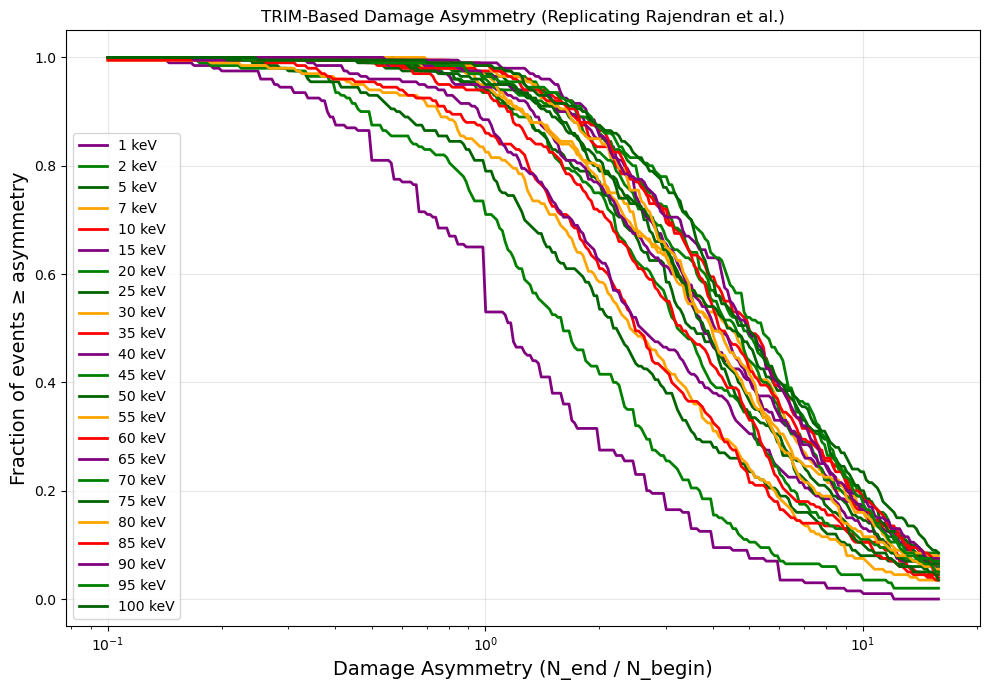


=== Orientation Prediction Efficiency ===
1 keV: threshold=3.667, efficiency=13.0%
2 keV: threshold=2.571, efficiency=32.0%
5 keV: threshold=2.429, efficiency=45.5%
7 keV: threshold=2.125, efficiency=56.5%
10 keV: threshold=1.875, efficiency=64.5%
15 keV: threshold=1.452, efficiency=76.0%
20 keV: threshold=1.068, efficiency=93.0%
25 keV: threshold=1.041, efficiency=94.0%
30 keV: threshold=1.026, efficiency=94.5%
35 keV: threshold=1.230, efficiency=87.5%
40 keV: threshold=1.059, efficiency=94.5%
45 keV: threshold=1.011, efficiency=96.0%
50 keV: threshold=1.051, efficiency=97.0%
55 keV: threshold=1.007, efficiency=96.5%
60 keV: threshold=1.062, efficiency=97.5%
65 keV: threshold=1.020, efficiency=96.5%
70 keV: threshold=1.021, efficiency=98.5%
75 keV: threshold=1.009, efficiency=95.0%
80 keV: threshold=1.021, efficiency=98.5%
85 keV: threshold=1.019, efficiency=98.5%
90 keV: threshold=1.084, efficiency=99.0%
95 keV: threshold=1.029, efficiency=96.5%
100 keV: threshold=1.038, efficiency=

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 1. Load data
# ============================================

# REPLACE THIS with your actual filename
df = pd.read_csv("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv")

# Ensure column names match your file exactly
df.columns = ["x", "y", "z", "ion", "energy"]

# Convert to numeric if needed
df = df.apply(pd.to_numeric, errors='ignore')


# ============================================
# 2. Compute asymmetry for each track
# ============================================

def compute_asymmetry(track_df):
    """
    Compute asymmetry exactly as in Rajendran et al.
    Using +x projection because recoil axis = +x.
    """
    s = track_df["x"].values  # projection onto +x axis
    
    if len(s) < 3:
        return np.nan
    
    s_min = s.min()
    s_max = s.max()
    L = s_max - s_min
    if L == 0:
        return np.nan

    # Third points
    b_end  = s_min + L/3
    e_start = s_min + 2*L/3

    # Count defects in beginning / end thirds
    N_begin = np.sum((s >= s_min) & (s < b_end))
    N_end   = np.sum((s >= e_start) & (s <= s_max))

    if N_begin == 0:
        return np.nan
    
    return N_end / N_begin


# Group by energy and ion_number and compute asymmetries
asym_data = []

for (E, ion), track in df.groupby(["energy", "ion"]):
    A = compute_asymmetry(track)
    if not np.isnan(A):
        asym_data.append([E, ion, A])

asym_df = pd.DataFrame(asym_data, columns=["energy", "ion", "asymmetry"])


# ============================================
# 3. Build cumulative asymmetry curves
# ============================================

def cumulative_curve(asymmetries, x_grid):
    """
    Compute F(x) = fraction of events with A >= x
    """
    A = np.array(asymmetries)
    return np.array([(A >= x).mean() for x in x_grid])


# Energies to plot (sorted)
energies = sorted(asym_df["energy"].unique())

# X-axis (damage asymmetry) – log spaced like the paper
x_grid = np.logspace(-1, 1.2, 300)


# ============================================
# 4. Plot cumulative curves (left panel of paper)
# ============================================

plt.figure(figsize=(10, 7))

colors = ["purple", "green", "darkgreen", "orange", "red"]
color_map = {}

# Map sorted energies to colors
for i, E in enumerate(energies):
    color_map[E] = colors[i % len(colors)]

for E in energies:
    A = asym_df[asym_df["energy"] == E]["asymmetry"].values
    F = cumulative_curve(A, x_grid)
    plt.plot(x_grid, F, lw=2, color=color_map[E], label=f"{int(E)} keV")

plt.xscale("log")
plt.xlabel("Damage Asymmetry (N_end / N_begin)", fontsize=14)
plt.ylabel("Fraction of events ≥ asymmetry", fontsize=14)
plt.title("TRIM-Based Damage Asymmetry (Replicating Rajendran et al.)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================
# 5. Compute 5% false-positive threshold + efficiency
# ============================================

def orientation_efficiency(asymmetries, fp_target=0.05):
    """
    Compute the optimal asymmetry threshold t (>1) such that:
      - False positive rate (wrong orientation) <= fp_target
      - Efficiency (correct & oriented) is maximized

    asymmetries: array-like of A = N_end / N_begin for one energy.
    """

    A = np.array(asymmetries)
    N = len(A)
    if N == 0:
        return np.nan, np.nan

    # Magnitude of asymmetry (>=1)
    A_mag = np.where(A >= 1, A, 1.0 / A)

    # "wrong sign" means more damage at the beginning
    is_wrong = A < 1

    # Candidate thresholds: sorted unique A_mag > 1
    candidates = np.sort(np.unique(A_mag[A_mag > 1.0]))
    if len(candidates) == 0:
        return np.nan, np.nan

    best_eff = 0.0
    best_t = candidates[0]

    for t in candidates:
        oriented = A_mag >= t
        if oriented.sum() == 0:
            continue

        # false positives: oriented AND wrong sign
        fp = np.logical_and(oriented, is_wrong).sum() / N

        if fp <= fp_target:
            # efficiency: oriented AND correct sign
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    return best_t, best_eff


print("\n=== Orientation Prediction Efficiency ===")
for E in energies:
    A = asym_df[asym_df["energy"] == E]["asymmetry"].values
    x_cut, eff = orientation_efficiency(A)
    print(f"{int(E)} keV: threshold={x_cut:.3f}, efficiency={eff*100:.1f}%")

/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_82974/1614570316.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


10 keV threshold = 1.875
10 keV efficiency = 0.645


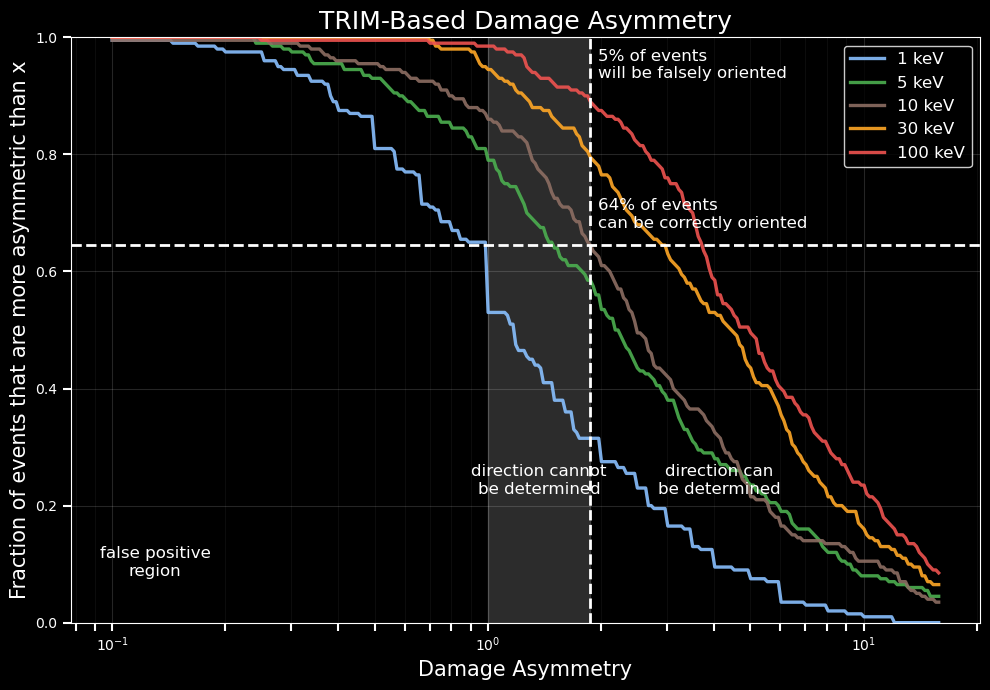

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 1. Load data
# ============================================

df = pd.read_csv("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv")

df.columns = ["x", "y", "z", "ion", "energy"]
df = df.apply(pd.to_numeric, errors='ignore')

# ============================================
# 2. Compute asymmetry for each track
# ============================================

def compute_asymmetry(track_df):
    s = track_df["x"].values  # project onto +x
    
    if len(s) < 3:
        return np.nan
    
    s_min = s.min()
    s_max = s.max()
    L = s_max - s_min
    if L == 0:
        return np.nan

    b_end  = s_min + L/3
    e_start = s_min + 2*L/3

    N_begin = np.sum((s >= s_min) & (s < b_end))
    N_end   = np.sum((s >= e_start) & (s <= s_max))

    if N_begin == 0:
        return np.nan

    return N_end / N_begin

asym_data = []

for (E, ion), track in df.groupby(["energy", "ion"]):
    A = compute_asymmetry(track)
    if not np.isnan(A):
        asym_data.append([E, ion, A])

asym_df = pd.DataFrame(asym_data, columns=["energy", "ion", "asymmetry"])

# ============================================
# 3. Only keep energies 1, 5, 10, 30, 100 keV
# ============================================

energies_to_plot = [1, 5, 10, 30, 100]
plot_df = asym_df[asym_df["energy"].isin(energies_to_plot)]

# Sorting ensures curves appear in the same order each time
plot_df = plot_df.sort_values("energy")

# ============================================
# 4. Compute cumulative curves
# ============================================

def cumulative_curve(asymmetries, x_grid):
    A = np.array(asymmetries)
    return np.array([(A >= x).mean() for x in x_grid])

x_grid = np.logspace(-1, 1.2, 300)

# ============================================
# 5. Orientation threshold for 10 keV (to add dashed lines)
# ============================================

def orientation_efficiency(asymmetries, fp_target=0.05):
    A = np.array(asymmetries)
    N = len(A)

    A_mag = np.where(A >= 1, A, 1.0 / A)
    is_wrong = A < 1

    candidates = np.sort(np.unique(A_mag[A_mag > 1.0]))
    if len(candidates) == 0:
        return np.nan, np.nan

    best_eff = 0.0
    best_t = candidates[0]

    for t in candidates:
        oriented = A_mag >= t
        if oriented.sum() == 0:
            continue

        fp = np.logical_and(oriented, is_wrong).sum() / N

        if fp <= fp_target:
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    return best_t, best_eff

A10 = plot_df[plot_df["energy"] == 10]["asymmetry"].values
threshold_10, eff_10 = orientation_efficiency(A10)

print("10 keV threshold =", threshold_10)
print("10 keV efficiency =", eff_10)

# ============================================
# 6. PERFECT RAJENDRAN-STYLE PLOT (corrected)
# ============================================

fig, ax = plt.subplots(figsize=(10, 7))

# --- BLACK BACKGROUND ---
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# --- White axes ---
for spine in ax.spines.values():
    spine.set_color("white")

ax.tick_params(axis='both', which='both',
               colors='white',
               width=1.5,
               length=6)

ax.grid(True, which="major", color="white", alpha=0.15)
ax.grid(True, which="minor", color="white", alpha=0.05)

colors = {
    1:  "#89c0ff",
    5:  "#4caf50",
    10: "#8d6e63",
    30: "#ffa726",
    100:"#ef5350"
}

# --- Plot cumulative curves ---
for E in energies_to_plot:
    A = plot_df[plot_df["energy"] == E]["asymmetry"].values
    F = cumulative_curve(A, x_grid)
    ax.plot(x_grid, F, lw=2.4, color=colors[E], label=f"{E} keV", alpha=0.9)

# -------------------------------------------------------
# CORRECT RAJENDRAN SHADING + THRESHOLD LINE + REGIONS
# -------------------------------------------------------

# Region 1 → FALSE POSITIVE: A < 1 (no shading needed)
# Region 2 → UNDETERMINED: 1 < A < threshold_10  (THIS is the shaded region)
ax.axvspan(1.0, threshold_10, color="gray", alpha=0.35)

# Region 3 → DIRECTION CAN BE DETERMINED: A > threshold_10 (no shading)

# Correct vertical and horizontal threshold lines
ax.axvline(threshold_10, color="white", linestyle="--", linewidth=2)
ax.axhline(eff_10,      color="white", linestyle="--", linewidth=2)

# -------------------------------------------------------
# Labels, axes, legend
# -------------------------------------------------------

ax.set_xscale("log")
ax.set_ylim(0, 1.0)

ax.set_xlabel("Damage Asymmetry", fontsize=15, color="white")
ax.set_ylabel("Fraction of events that are more asymmetric than x",
              fontsize=15, color="white")
ax.set_title("TRIM-Based Damage Asymmetry", fontsize=18, color="white")

legend = ax.legend(facecolor="black", edgecolor="white", fontsize=12)
for text in legend.get_texts():
    text.set_color("white")

# -------------------------------------------------------
# CORRECT RAJENDRAN ANNOTATIONS
# -------------------------------------------------------

# Top annotation (false positive)
ax.text(threshold_10 * 1.05, 0.93,
        "5% of events\nwill be falsely oriented",
        fontsize=12, color='white')

# Efficiency annotation
ax.text(threshold_10 * 1.05, eff_10 + 0.03,
        f"{eff_10*100:.0f}% of events\ncan be correctly oriented",
        fontsize=12, color='white')

# False positive region
ax.text(0.13, 0.08,
        "false positive\nregion",
        fontsize=12, color='white', ha='center')

# UNDERTMINED region (centered in the shaded area)
ax.text(np.sqrt(1.0 * threshold_10), 0.22,
        "direction cannot\nbe determined",
        fontsize=12, color='white', ha='center')

# DIRECTION CAN BE DETERMINED
ax.text(threshold_10 * 2.2, 0.22,
        "direction can\nbe determined",
        fontsize=12, color='white', ha='center')

plt.tight_layout()
plt.show()

/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_82974/3683402306.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


10 keV threshold = 1.875
10 keV efficiency = 0.645


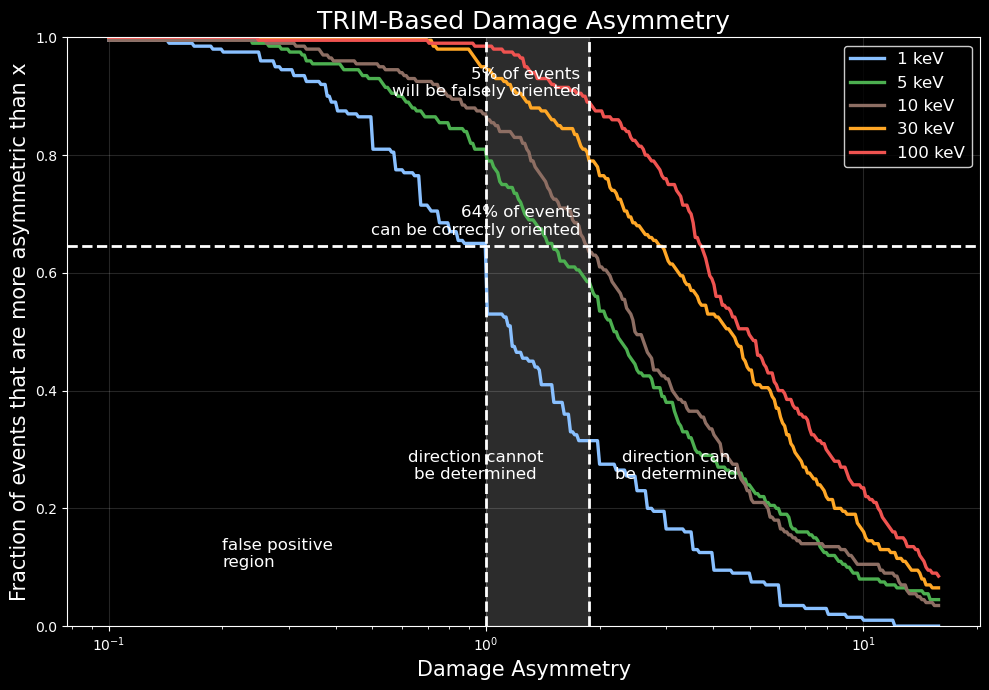

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 1. Load data
# ============================================

df = pd.read_csv("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv")
df.columns = ["x", "y", "z", "ion", "energy"]
df = df.apply(pd.to_numeric, errors='ignore')

# ============================================
# 2. Compute asymmetry for each track
# ============================================

def compute_asymmetry(track_df):
    s = track_df["x"].values
    
    if len(s) < 3:
        return np.nan

    s_min, s_max = s.min(), s.max()
    L = s_max - s_min
    if L == 0:
        return np.nan

    b_end  = s_min + L/3
    e_start = s_min + 2*L/3

    N_begin = np.sum((s >= s_min) & (s < b_end))
    N_end   = np.sum((s >= e_start) & (s <= s_max))

    if N_begin == 0:
        return np.nan

    return N_end / N_begin


asym_data = []
for (E, ion), track in df.groupby(["energy", "ion"]):
    A = compute_asymmetry(track)
    if not np.isnan(A):
        asym_data.append([E, ion, A])

asym_df = pd.DataFrame(asym_data, columns=["energy", "ion", "asymmetry"])

# ============================================
# 3. Select energies matching Rajendran
# ============================================

energies_to_plot = [1, 5, 10, 30, 100]
plot_df = asym_df[asym_df["energy"].isin(energies_to_plot)]
plot_df = plot_df.sort_values("energy")

# ============================================
# 4. Compute cumulative (survival) curves
# ============================================

def cumulative_curve(A, x_grid):
    A = np.array(A)
    return np.array([(A >= x).mean() for x in x_grid])

x_grid = np.logspace(-1, 1.2, 400)

# ============================================
# 5. Rajendran-style threshold for 10 keV
# ============================================

def orientation_efficiency(A, fp_target=0.05):
    A = np.array(A)
    N = len(A)

    A_mag = np.where(A >= 1, A, 1.0 / A)
    is_wrong = A < 1

    candidates = np.sort(np.unique(A_mag[A_mag > 1.0]))
    if len(candidates) == 0:
        return np.nan, np.nan

    best_eff = 0
    best_t = candidates[0]

    for t in candidates:
        oriented = A_mag >= t
        if oriented.sum() == 0:
            continue

        fp = np.logical_and(oriented, is_wrong).sum() / N
        if fp <= fp_target:
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    return best_t, best_eff

A10 = plot_df[plot_df["energy"] == 10]["asymmetry"].values
threshold_10, eff_10 = orientation_efficiency(A10)

print("10 keV threshold =", threshold_10)
print("10 keV efficiency =", eff_10)

###############################################
# PART 1 — EXACT RAJENDRAN REPLICA
###############################################

fig, ax = plt.subplots(figsize=(10, 7))

# Black background
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# White axes
for spine in ax.spines.values():
    spine.set_color("white")

ax.tick_params(axis='both', colors="white")

# Grid
ax.grid(True, color="white", alpha=0.15)

# Colors identical to Rajendran
colors = {
    1:  "#89c0ff",
    5:  "#4caf50",
    10: "#8d6e63",
    30: "#ffa726",
    100:"#ef5350"
}

# Plot curves
for E in energies_to_plot:
    A = plot_df[plot_df["energy"] == E]["asymmetry"].values
    F = cumulative_curve(A, x_grid)
    ax.plot(x_grid, F, lw=2.4, color=colors[E], label=f"{E} keV")

# --- Shaded region (dark grey) ---
ax.axvspan(1.0, threshold_10, color="gray", alpha=0.35)

# --- Vertical dashed lines ---
ax.axvline(1.0, color="white", linestyle="--", linewidth=2)
ax.axvline(threshold_10, color="white", linestyle="--", linewidth=2)

# --- Horizontal dashed lines ---
# bottom = fraction of correctly oriented tracks
ax.axhline(eff_10, color="white", linestyle="--", linewidth=2)

# top = false-positive bound (should be ~0.95)
F_top = (A10 >= threshold_10).mean()
ax.axhline(F_top, color="white", linestyle="--", linewidth=2)

# Axes scaling
ax.set_xscale("log")
ax.set_ylim(0,1)

# Labels (white)
ax.set_xlabel("Damage Asymmetry", fontsize=15, color="white")
ax.set_ylabel("Fraction of events that are more asymmetric than x",
              fontsize=15, color="white")
ax.set_title("TRIM-Based Damage Asymmetry", fontsize=18, color="white")

# Legend
leg = ax.legend(facecolor="black", edgecolor="white", fontsize=12)
for t in leg.get_texts():
    t.set_color("white")

###############################################################
# TEXT — exact placement to match Rajendran visually
###############################################################

# 5% FP annotation near threshold
ax.text(threshold_10 * 0.95, 0.95,
        "5% of events\nwill be falsely oriented",
        color="white", ha="right", va="top", fontsize=12)

# Efficiency annotation
ax.text(threshold_10 * 0.95, eff_10 + 0.02,
        f"{eff_10*100:.0f}% of events\ncan be correctly oriented",
        color="white", ha="right", fontsize=12)

# Regions
ax.text(0.2, 0.1, "false positive\nregion",
        color="white", ha="left", fontsize=12)

ax.text(threshold_10/2, 0.25,
        "direction cannot\nbe determined",
        color="white", ha="center", fontsize=12)

ax.text(threshold_10*1.7, 0.25,
        "direction can\nbe determined",
        color="white", ha="center", fontsize=12)

plt.tight_layout()
plt.show()

In [35]:
print(sorted(asym_df["energy"].unique()))

[1.0, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]


/var/folders/wv/wqt6hj5j10x18q4_x16rqnvc0000gn/T/ipykernel_82974/1401050571.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


10 keV threshold = 1.875
10 keV efficiency = 0.645


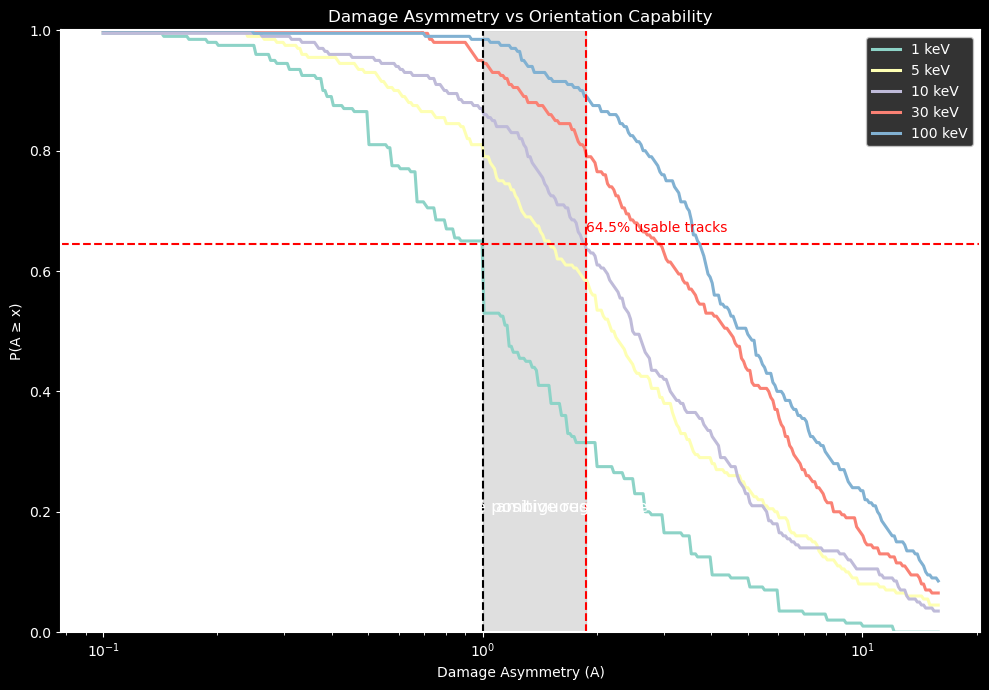

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 1. Load data
# ============================================

df = pd.read_csv("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/nov3srim/vacancies.csv")
df.columns = ["x", "y", "z", "ion", "energy"]
df = df.apply(pd.to_numeric, errors='ignore')

# ============================================
# 2. Compute asymmetry for each track
# ============================================

def compute_asymmetry(track_df):
    s = track_df["x"].values
    
    if len(s) < 3:
        return np.nan

    s_min, s_max = s.min(), s.max()
    L = s_max - s_min
    if L == 0:
        return np.nan

    b_end  = s_min + L/3
    e_start = s_min + 2*L/3

    N_begin = np.sum((s >= s_min) & (s < b_end))
    N_end   = np.sum((s >= e_start) & (s <= s_max))

    if N_begin == 0:
        return np.nan

    return N_end / N_begin


asym_data = []
for (E, ion), track in df.groupby(["energy", "ion"]):
    A = compute_asymmetry(track)
    if not np.isnan(A):
        asym_data.append([E, ion, A])

asym_df = pd.DataFrame(asym_data, columns=["energy", "ion", "asymmetry"])

# ============================================
# 3. Select energies matching Rajendran
# ============================================

energies_to_plot = [1, 5, 10, 30, 100]
plot_df = asym_df[asym_df["energy"].isin(energies_to_plot)]
plot_df = plot_df.sort_values("energy")

# ============================================
# 4. Compute cumulative (survival) curves
# ============================================

def cumulative_curve(A, x_grid):
    A = np.array(A)
    return np.array([(A >= x).mean() for x in x_grid])

x_grid = np.logspace(-1, 1.2, 400)

# ============================================
# 5. Rajendran-style threshold for 10 keV
# ============================================

def orientation_efficiency(A, fp_target=0.05):
    A = np.array(A)
    N = len(A)

    A_mag = np.where(A >= 1, A, 1.0 / A)
    is_wrong = A < 1

    candidates = np.sort(np.unique(A_mag[A_mag > 1.0]))
    if len(candidates) == 0:
        return np.nan, np.nan

    best_eff = 0
    best_t = candidates[0]

    for t in candidates:
        oriented = A_mag >= t
        if oriented.sum() == 0:
            continue

        fp = np.logical_and(oriented, is_wrong).sum() / N
        if fp <= fp_target:
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    return best_t, best_eff

A10 = plot_df[plot_df["energy"] == 10]["asymmetry"].values
threshold_10, eff_10 = orientation_efficiency(A10)

print("10 keV threshold =", threshold_10)
print("10 keV efficiency =", eff_10)

###############################################
# PART 2 — CLEAN MODERN VERSION
###############################################

fig, ax = plt.subplots(figsize=(10, 7))

# Clean white background
ax.set_facecolor("white")

# Simple style
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Plot curves
for E in energies_to_plot:
    A = plot_df[plot_df["energy"] == E]["asymmetry"].values
    F = cumulative_curve(A, x_grid)
    ax.plot(x_grid, F, lw=2.2, label=f"{E} keV")

# Lines
ax.axvline(1.0, color="black", linestyle="--")
ax.axvline(threshold_10, color="red", linestyle="--")
ax.axhline(eff_10, color="red", linestyle="--")

# Shading
ax.axvspan(1.0, threshold_10, color="gray", alpha=0.25)

# Axis scale
ax.set_xscale("log")
ax.set_ylim(0,1)

ax.set_xlabel("Damage Asymmetry (A)")
ax.set_ylabel("P(A ≥ x)")
ax.set_title("Damage Asymmetry vs Orientation Capability")

# Labels
ax.text(threshold_10, eff_10+0.02,
        f"{eff_10*100:.1f}% usable tracks",
        ha="left", color="red")

ax.text(0.8, 0.2, "false positive region", fontsize=12)
ax.text((1+threshold_10)/2, 0.2, "ambiguous", fontsize=12, ha="center")
ax.text(threshold_10*1.2, 0.2, "directional", fontsize=12)

ax.legend()

plt.tight_layout()
plt.show()
plt.show()

[INFO] Loaded 1000 tracks.

=== GLOBAL RAJENDRAN STATS ===
Raj threshold (global): 13.462
Raj efficiency (global): 0.045
Raj accuracy (from CSV): 0.490

=== PER-keV SUMMARY (binned) ===
    E_keV   N  frac_A>1  Raj_threshold   Raj_eff  Raj_accuracy
0       1   3  0.333333      10.000000  0.333333      0.666667
1       2   7  0.428571            NaN  0.000000      0.571429
2       3  14  0.571429       4.333333  0.071429      0.500000
3       4  10  0.600000       3.571429  0.100000      0.400000
4       5  14  0.714286       2.833333  0.357143      0.500000
5       6   7  0.714286       1.611111  0.714286      0.714286
6       7   7  0.571429            NaN  0.000000      0.714286
7       8   7  0.285714      10.666667  0.142857      0.285714
8       9   5  0.800000       2.055556  0.600000      0.600000
9      10   5  0.600000       2.000000  0.400000      1.000000
10     11   6  0.666667       4.733333  0.666667      0.666667
11     12  17  0.470588            NaN  0.000000      0.52

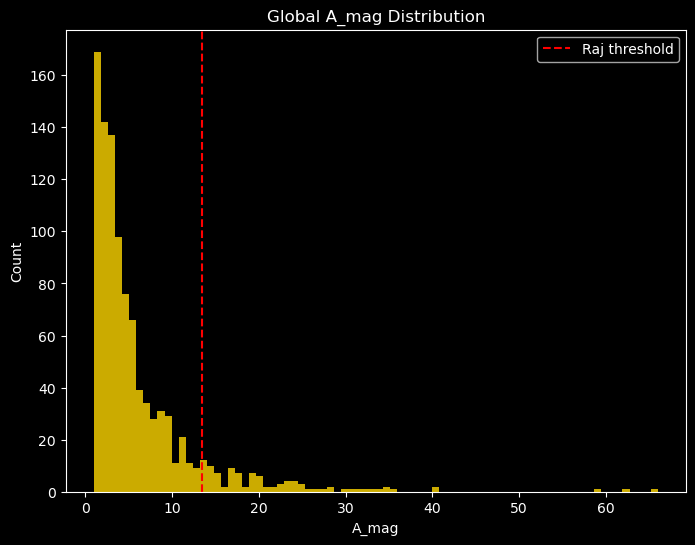

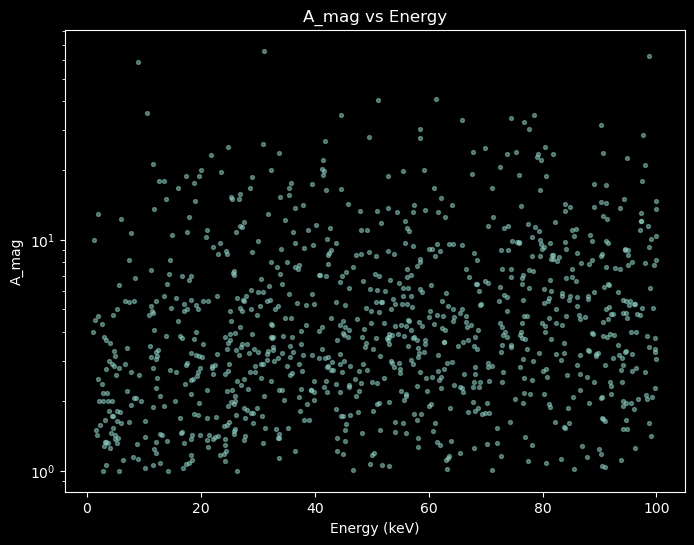

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Compute Rajendran threshold for a set of A values
# ------------------------------------------------------------

def compute_raj_threshold(A, fp_target=0.05):
    A = np.array(A, float)

    A_mag = np.where(A >= 1, A, 1/A)
    is_wrong = A < 1
    N = len(A)

    cand = np.sort(np.unique(A_mag[A_mag > 1]))
    if len(cand) == 0:
        return np.nan, np.nan

    best_t, best_eff = np.nan, 0

    for t in cand:
        oriented = (A_mag >= t)
        if oriented.sum() == 0:
            continue

        fp = np.logical_and(oriented, is_wrong).sum() / N
        if fp <= fp_target:
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    return best_t, best_eff


# ------------------------------------------------------------
# MAIN cleaner analysis
# ------------------------------------------------------------

def analyze_raj_clean(csv_path):
    df = pd.read_csv(csv_path)

    print("[INFO] Loaded", len(df), "tracks.")

    # ---------------------------
    # Global Rajendran stats
    # ---------------------------

    A = df["A"].values
    T_global, eff_global = compute_raj_threshold(A)

    print("\n=== GLOBAL RAJENDRAN STATS ===")
    print(f"Raj threshold (global): {T_global:.3f}")
    print(f"Raj efficiency (global): {eff_global:.3f}")
    print(f"Raj accuracy (from CSV): {df['raj_correct'].mean():.3f}")

    # ---------------------------
    # Per-keV binned stats
    # ---------------------------

    df["E_round"] = df["true_energy_keV"].round().astype(int)

    out = []

    for E, g in df.groupby("E_round"):
        A = g["A"].values
        T, eff = compute_raj_threshold(A)

        out.append([
            E, len(g),
            np.mean(A > 1),
            T, eff,
            g["raj_correct"].mean(),
        ])

    summary = pd.DataFrame(
        out,
        columns=[
            "E_keV", "N",
            "frac_A>1",
            "Raj_threshold",
            "Raj_eff",
            "Raj_accuracy"
        ]
    )

    print("\n=== PER-keV SUMMARY (binned) ===")
    print(summary.head(20))

    # ---------------------------
    # Plot global distributions
    # ---------------------------

    plt.figure(figsize=(8,6))
    plt.hist(df["A_mag"], bins=80, color="gold", alpha=0.8)
    plt.axvline(T_global, color='red', linestyle='--', label="Raj threshold")
    plt.xlabel("A_mag")
    plt.ylabel("Count")
    plt.title("Global A_mag Distribution")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    plt.scatter(df["true_energy_keV"], df["A_mag"], s=8, alpha=0.5)
    plt.xlabel("Energy (keV)")
    plt.ylabel("A_mag")
    plt.yscale("log")
    plt.title("A_mag vs Energy")
    plt.show()

    return summary


csv_path = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/protoype/mnpe_vs_raj_comparison.csv"
summary = analyze_raj_clean(csv_path)

In [44]:
import numpy as np
import pandas as pd

def analyze_mnpe_vs_raj(csv_path, fp_target=0.05):
    print("\n[INFO] Loading CSV:", csv_path)
    df = pd.read_csv(csv_path)

    required = ["true_energy_keV","true_parity","A_mag","mnpe_correct","raj_pred","raj_correct"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError("CSV missing columns: " + str(missing))

    # Clean NaNs
    df = df.dropna(subset=["A_mag","true_parity"])

    print(f"[INFO] Loaded {len(df)} tracks.")

    # ============================================================
    # GLOBAL RAJENDRAN THRESHOLD ESTIMATION (the real thing)
    # ============================================================
    A = df["A_mag"].values
    true_parity = df["true_parity"].values
    is_wrong = (true_parity == 0)   # 0 = left = negative orientation case

    candidates = np.sort(np.unique(A[A > 1]))  # sensible candidates
    best_t = None
    best_eff = -1
    N = len(df)

    for t in candidates:
        oriented = (A >= t)
        fp = np.logical_and(oriented, is_wrong).sum() / N
        if fp <= fp_target:
            eff = np.logical_and(oriented, ~is_wrong).sum() / N
            if eff > best_eff:
                best_eff = eff
                best_t = t

    print("\n=== GLOBAL RAJENDRAN THRESHOLD ===")
    print(f"False positive constraint: {fp_target*100:.1f}%")
    print(f"Optimal threshold = {best_t:.3f}")
    print(f"Raj efficiency   = {best_eff:.3f}")

    # ============================================================
    # APPLY THE THRESHOLD
    # ============================================================
    df["raj_pred_recomputed"] = (df["A_mag"] >= best_t).astype(int)
    df["raj_correct_recomputed"] = (df["raj_pred_recomputed"] == df["true_parity"]).astype(int)

    # ============================================================
    # FINAL SUMMARY
    # ============================================================
    mnpe_acc = df["mnpe_correct"].mean()
    raj_acc = df["raj_correct_recomputed"].mean()

    print("\n===== FINAL SUMMARY =====")
    print(f"MNPE accuracy (from CSV):      {mnpe_acc*100:.2f}%")
    print(f"Raj accuracy (recomputed):     {raj_acc*100:.2f}%")

    return df, best_t, mnpe_acc, raj_acc


df, T, mnpe_acc, raj_acc = analyze_mnpe_vs_raj("/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/protoype/mnpe_vs_raj_comparison.csv")


[INFO] Loading CSV: /Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/protoype/mnpe_vs_raj_comparison.csv
[INFO] Loaded 1000 tracks.

=== GLOBAL RAJENDRAN THRESHOLD ===
False positive constraint: 5.0%
Optimal threshold = 13.462
Raj efficiency   = 0.045

===== FINAL SUMMARY =====
MNPE accuracy (from CSV):      91.90%
Raj accuracy (recomputed):     50.30%


[INFO] Computing A_mag from raw cascades...

[INFO] Binning tracks by target energies...
[INFO] Energy 1 keV → closest = 1.02 keV (N=1)
[INFO] Energy 3 keV → closest = 3.02 keV (N=1)
[INFO] Energy 10 keV → closest = 10.12 keV (N=1)
[INFO] Energy 30 keV → closest = 30.02 keV (N=1)
[INFO] Energy 100 keV → closest = 100.00 keV (N=1)

===== ENERGY-BY-ENERGY COMPARISON =====
 Energy_keV  N_tracks  Raj_A_threshold  Raj_efficiency  MNPE_accuracy
   1.017167         1         0.066667             0.0            1.0
   3.017674         1         0.266667             0.0            0.0
  10.119684         1         0.118280             0.0            1.0
  30.021658         1         0.402778             0.0            1.0
  99.998979         1         0.500000             0.0            1.0

Plotting Raj curves…


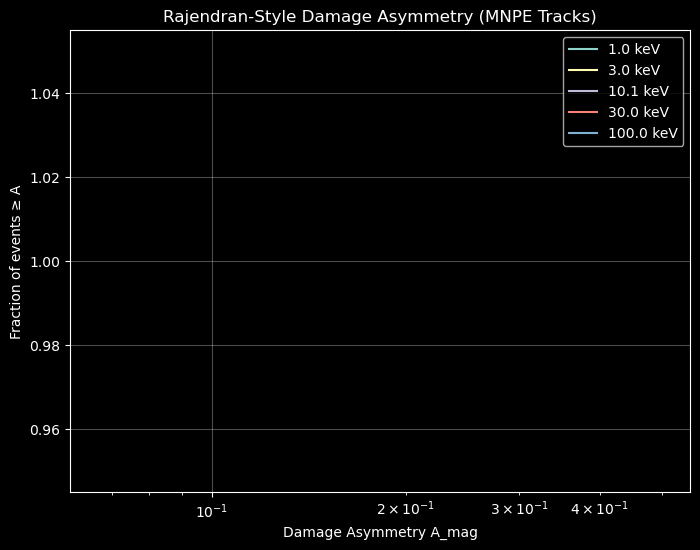

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------
# 1. Rajendran asymmetry metric
# ---------------------------------------------------------
def compute_A_mag(df):
    """
    Compute Rajendran asymmetry A_mag = |N_right - N_left| / (N_right + N_left)
    Using x-axis sign.
    """
    x = df["x"].values
    N_left  = np.sum(x < 0)
    N_right = np.sum(x > 0)
    total = N_left + N_right
    if total == 0:
        return 0.0
    return abs(N_right - N_left) / total


# ---------------------------------------------------------
# 2. Load MNPE CSV
# ---------------------------------------------------------
def load_mnpe_csv(csv_path):
    df = pd.read_csv(csv_path)
    needed = ["true_energy_keV", "true_parity", "pred_parity", "csv_path"]
    for c in needed:
        if c not in df.columns:
            raise ValueError(f"Missing column {c}")
    return df


# ---------------------------------------------------------
# 3. Compute A_mag for each MNPE track
# ---------------------------------------------------------
def compute_A_for_all(df):
    A_list = []

    print("[INFO] Computing A_mag from raw cascades...")
    for i, row in df.iterrows():
        track_csv = row["csv_path"]
        raw = pd.read_csv(track_csv)

        # Compute asymmetry
        A = compute_A_mag(raw)
        A_list.append(A)

    df["A_mag"] = A_list
    return df


# ---------------------------------------------------------
# 4. Group tracks into energy bins
# ---------------------------------------------------------
def bin_tracks_by_closest_energy(df, target_energies):
    """
    For each target energy, find the closest actual energy in the MNPE dataset.
    """
    actual_E = df["true_energy_keV"].values
    selected = {}

    for E0 in target_energies:
        k = np.argmin(abs(actual_E - E0))
        E_sel = actual_E[k]
        group = df[np.isclose(df["true_energy_keV"], E_sel, atol=1e-6)]
        selected[E_sel] = group
        print(f"[INFO] Energy {E0} keV → closest = {E_sel:.2f} keV (N={len(group)})")

    return selected


# ---------------------------------------------------------
# 5. Compute Rajendran efficiency at each energy
# ---------------------------------------------------------
def compute_raj_metrics(group_df, fp_rate=0.05):
    A_vals = np.sort(group_df["A_mag"].values)

    if len(A_vals) == 0:
        return np.nan, np.nan

    # False positive threshold = 5% largest A values get rejected
    idx = int((1 - fp_rate) * len(A_vals))
    if idx >= len(A_vals):
        idx = len(A_vals) - 1

    A_thresh = A_vals[idx]

    # Efficiency = fraction above threshold
    eff = np.mean(A_vals > A_thresh)

    return A_thresh, eff


# ---------------------------------------------------------
# 6. Compute MNPE accuracy per energy
# ---------------------------------------------------------
def compute_mnpe_accuracy(group_df):
    correct = np.sum(group_df["pred_parity"] == group_df["true_parity"])
    total = len(group_df)
    return correct / total if total > 0 else np.nan


# ---------------------------------------------------------
# 7. Plot Rajendran-style asymmetry curves
# ---------------------------------------------------------
def plot_raj_curves(binned_data):
    plt.figure(figsize=(8,6))

    for E, dfE in binned_data.items():
        A = np.sort(dfE["A_mag"].values)
        if len(A) == 0:
            continue

        frac = 1 - np.arange(len(A))/len(A)
        plt.step(A, frac, label=f"{E:.1f} keV")

    plt.xscale("log")
    plt.xlabel("Damage Asymmetry A_mag")
    plt.ylabel("Fraction of events ≥ A")
    plt.title("Rajendran-Style Damage Asymmetry (MNPE Tracks)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# ---------------------------------------------------------
# 8. Comparison driver
# ---------------------------------------------------------
def run_comparison(csv_path, target_energies=[1,3,10,30,100]):
    df = load_mnpe_csv(csv_path)
    df = compute_A_for_all(df)

    print("\n[INFO] Binning tracks by target energies...")
    binned = bin_tracks_by_closest_energy(df, target_energies)

    rows = []

    for E, dfE in binned.items():
        if len(dfE) == 0:
            continue

        A_thresh, raj_eff = compute_raj_metrics(dfE, fp_rate=0.05)
        mnpe_acc = compute_mnpe_accuracy(dfE)

        rows.append([E, len(dfE), A_thresh, raj_eff, mnpe_acc])

    comparison_df = pd.DataFrame(rows, columns=[
        "Energy_keV", "N_tracks",
        "Raj_A_threshold", "Raj_efficiency",
        "MNPE_accuracy",
    ])

    print("\n===== ENERGY-BY-ENERGY COMPARISON =====")
    print(comparison_df.to_string(index=False))

    print("\nPlotting Raj curves…")
    plot_raj_curves(binned)

    return comparison_df


# ---------------------------------------------------------
# MAIN CALL
# ---------------------------------------------------------
csv_path = "/Users/cbharathulwar/Documents/Research/Walsworth/Code/SBI/srim-sbi/data/results/Nov18_mnpe.csv"

results = run_comparison(csv_path)